In [1]:
import csv
import cv2
import numpy as np
import os
import math

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

STEERING_CORRECTION = 0.15
BATCH_SIZE = 512

class SteeringData:
    def __init__(self, path, angle, flipped):
        self.path    = path
        self.angle   = angle
        self.flipped = flipped
        self.shadow  = 0
        self.bright  = 0
        self.blur    = 0


def read_csv(csv_file):
    images = []
    angles = []
    print("Reading data from csv file....")
    with open(csv_file) as csvfile:
        reader = csv.reader(csvfile)

        csv_data = []

        corrections = []
        
        for line in reader:
            center_image_path = 'data/IMG/' + line[0].split('/')[-1]
            if os.path.isfile(center_image_path):
                center_angle = float(line[3])
                csv_data.append(SteeringData(center_image_path, center_angle, 0))
                csv_data.append(SteeringData(center_image_path, -center_angle, 1))

            left_image_path = 'data/IMG/' + line[1].split('/')[-1]
            if os.path.isfile(left_image_path):
                left_angle = float(line[3]) + STEERING_CORRECTION
                csv_data.append(SteeringData(left_image_path, left_angle, 0))
                csv_data.append(SteeringData(left_image_path, -left_angle, 1))

            right_image_path = 'data/IMG/' + line[2].split('/')[-1]
            if os.path.isfile(right_image_path):
                right_angle = float(line[3]) - STEERING_CORRECTION
                csv_data.append(SteeringData(right_image_path, right_angle, 0))
                csv_data.append(SteeringData(right_image_path, -right_angle, 1))


    print("Done. ")
    return shuffle(csv_data)



In [2]:
steering_data = read_csv('data/driving_log.csv')
training_set, validation_set = train_test_split(steering_data, test_size=0.2)

corrections = [item.angle for item in training_set]

print("\nTraining Set Size: {}".format(str(len(training_set))))
print("Validation Set Size: {}".format(str(len(validation_set))))

print("Max correction: {}".format(np.max(corrections)))
print("Min correction: {}".format(np.min(corrections)))



Reading data from csv file....
Done. 

Training Set Size: 20265
Validation Set Size: 5067
Max correction: 0.8999119
Min correction: -0.8999119


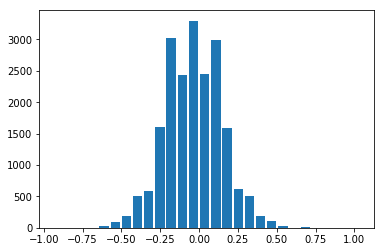

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

#
# Split the items into 25 bins
# from the minimum steering angle
# to the maximum. 
# 
bin_count = 25
min_bin = np.min(corrections)
max_bin = np.max(corrections)
spread = max_bin - min_bin
bin_size = spread / bin_count

bins = [min_bin + i * bin_size for i in range(bin_count)]
bins.append(max_bin + 0.10)

#
# Plot to visualize the initial distribution
#
bin_counts, bins_out = np.histogram(corrections, bins)
plt.bar(bins, np.append(bin_counts, 0), width=0.06)
plt.show()


In [4]:
import copy
import random

desired_count_per_bin = int(np.mean(bin_counts) * 1)
augments = np.float32((desired_count_per_bin - bin_counts) / bin_counts)
def augment_dataset(x):
    augment_tally = np.zeros_like(augments)
    augmented = []
    for i in range(len(x)):
        steering_data = x[i]
        
        augment_index = np.digitize(steering_data.angle, bins) - 1        
        augment_tally[augment_index] += augments[augment_index]
        number_to_augment = np.int32(augment_tally[augment_index])
        augment_tally[augment_index] -= number_to_augment
        
        for j in range(number_to_augment):
            new_steering_data = copy.deepcopy(steering_data)
            new_steering_data.shadow = int(np.random.uniform(0, 1) + 0.5)
            new_steering_data.blur   = int(np.random.uniform(0, 1) + 0.5)
            new_steering_data.bright = int(np.random.uniform(0, 1) + 0.5)
            augmented.append(new_steering_data)
        
    return augmented

#augmented = augment_dataset(training_set)
#training_set = training_set + augmented
print("\nTraining Set Size: {}".format(str(len(training_set))))
print("Validation Set Size: {}".format(str(len(validation_set))))



Training Set Size: 20265
Validation Set Size: 5067


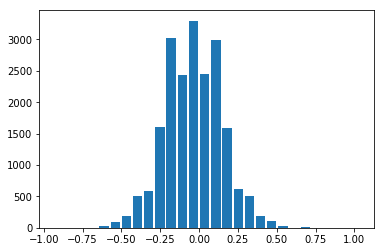

[-0.8999119  -0.82791895 -0.755926   -0.68393304 -0.61194009 -0.53994714
 -0.46795419 -0.39596124 -0.32396828 -0.25197533 -0.17998238 -0.10798943
 -0.03599648  0.03599648  0.10798943  0.17998238  0.25197533  0.32396828
  0.39596124  0.46795419  0.53994714  0.61194009  0.68393304  0.755926
  0.82791895  0.9999119 ]
[   3    1    4    2   34   99  186  499  589 1604 3024 2435 3299 2447 2984
 1593  614  504  193  104   36    1    5    1    4]


In [5]:
corrections = [item.angle for item in training_set]
bin_counts, bins = np.histogram(corrections, bins)
plt.bar(bins, np.append(bin_counts, 0), width=0.06)
plt.show()

print(bins)

print(bin_counts)


Training set size 8527


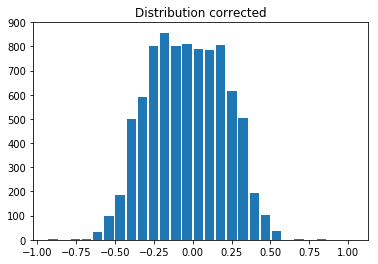

In [6]:
#
# Calculate the probability to keep any given item in a bin
# based on the count above/below the desired count per bin.
#
keep_probabilities = np.float32(1 / (bin_counts / desired_count_per_bin))

def should_keep(item):
    #
    # calc the probability to keep this item based on 
    # what bin it is in. 
    #
    probability_to_keep = keep_probabilities[np.digitize(item.angle, bins) - 1]
    
    #
    # get a random percentage
    #
    random_prob = np.random.uniform(0, 1)
    
    #
    # if the random percentage is less that the probability
    # to keep we keep it. (return True)
    # 
    return (random_prob <= probability_to_keep)

#
# Trim extra examples from the data set to fix distribution
#
trimmed_training_set = [x for x in training_set if should_keep(x)]

print("Training set size {}".format(str(len(trimmed_training_set))))

#
# re-plot to visualize the new distribution
#
corrections = [x.angle for x in trimmed_training_set]
bin_counts, bins = np.histogram(corrections, bins)
plt.bar(bins, np.append(bin_counts, 0), width=0.06)
plt.title("Distribution corrected")
plt.show()